<a href="https://colab.research.google.com/github/shuvad23/image-classification-projects/blob/main/Basic_Image_Classification_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic Image Classification using CNN

📌 Project Description

- This project demonstrates a basic image classification system built using Convolutional Neural Networks (CNNs) in PyTorch.


- The model learns visual features such as edges, shapes, and textures to classify images into predefined categories.

- Key Features

  - Custom Dataset and DataLoader

  - CNN model implementation from scratch

  - Training and validation loops

  - Accuracy and loss evaluation

1. Conceptual Overview:
   - How CNNs Work Before coding, it is helpful to visualize what the network is actually doing. A Standard Neural Network treats an image as a long flat list of numbers, losing spatial information. A CNN preserves the 2D structure of the image.



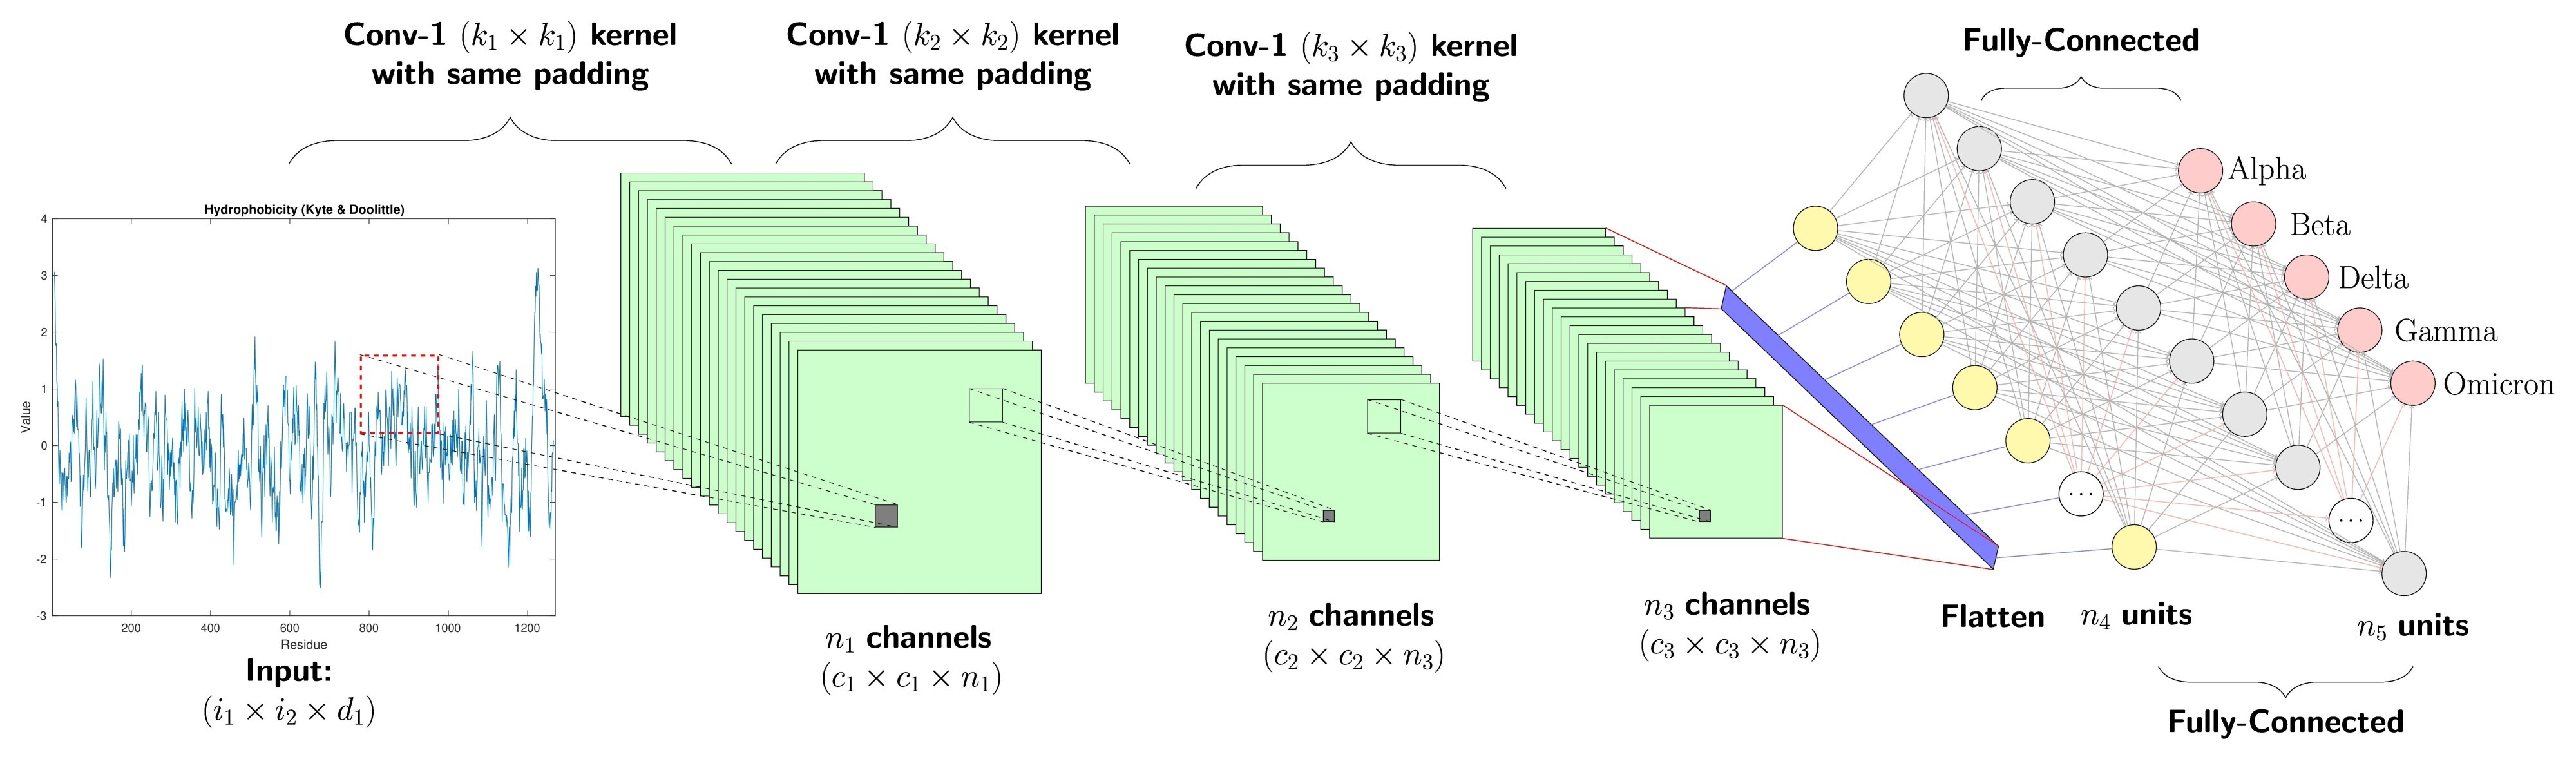

The process generally involves three main operations:

- **Convolution:** Filters slide over the image to detect features (edges, curves, textures).

- **Activation (ReLU):** Introduces non-linearity, helping the model learn complex patterns.

- **Pooling:** Reduces the size of the image (downsampling) to reduce computation and focus on the most important features.

In [2]:
# initialize dependency
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os

# 1. CUSTOM DATASET CLASS


In [3]:
# 1. CUSTOM DATASET CLASS
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform = None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted([dir.name for dir in self.root_dir.iterdir() if dir.is_dir()])
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

        # load all image paths and labels
        self.samples = []
        for cls in self.classes:
            cls_dir = self.root_dir / cls
            for img_path in cls_dir.glob('*.jpg'):
                self.samples.append((str(img_path),self.class_to_idx[cls]))

    # return the len of the samples
    def __len__(self):
        return len(self.samples)

    # return the specific sample at a given dataset
    def __getitem__(self, index):
        img_path, label = self.samples[index]
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(img)

        return image, label



# 2. CNN MODEL ARCHITECTURE


In [14]:
# 2. CNN MODEL ARCHITECTURE
class CNN_Classifier(nn.Module):
    """Custom CNN for image classification"""

    def __init__(self,num_classes = 10, input_channels = 3):
        super(CNN_Classifier, self).__init__()

        # Convolutional Block 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32,32,kernel_size=3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Convolutional Block 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(32,64,kernel_size=3,padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64,64,kernel_size=3,padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride = 2)
        )

        # convolutional Block 3
        self.conv3 = nn.Sequential(
            nn.Conv2d(64,128, kernel_size=3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128,128, kernel_size=3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )


        # Fully Connected Layers
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc(x)
        return x

# 3. TRAINING AND VALIDATION FUNCTIONS

In [12]:
# 3. TRAINING AND VALIDATION FUNCTIONS

def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        inputs , labels = inputs.to(device), labels.to(device)

        # zero gradients
        optimizer.zero_grad()

        #forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # backward pass and optimize
        loss.backward()
        optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicated = torch.max(outputs,1)
        total += labels.size(0)
        correct += (predicated == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc


def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicated = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicated == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc


# 4. MAIN TRAINING LOOP

In [6]:
# 4. MAIN TRAINING LOOP
def train_model(model, train_loader, val_loader, num_epochs=25,lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min',factor=0.5,patience=3)

    # Track metrics
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    best_val_acc = 0.0

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 50)

        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion,
                                           optimizer, device)

        # Validate
        val_loss, val_acc = validate(model, val_loader, criterion, device)

        # Update learning rate
        scheduler.step(val_loss)

        # Save metrics
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'Model saved! (Best Val Acc: {best_val_acc:.2f}%)')

    return model, history

# 5. VISUALIZATION FUNCTIONS

In [7]:
# 5. VISUALIZATION FUNCTIONS
def plot_training_history(history):
    """Plot training and validation metrics"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Loss plot
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)

    # Accuracy plot
    ax2.plot(history['train_acc'], label='Train Acc')
    ax2.plot(history['val_acc'], label='Val Acc')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

# 6. EXAMPLE USAGE

Using device: cuda

Epoch 1/10
--------------------------------------------------
Train Loss: 0.6450 | Train Acc: 70.00%
Val Loss: 0.6934 | Val Acc: 50.00%
Model saved! (Best Val Acc: 50.00%)

Epoch 2/10
--------------------------------------------------
Train Loss: 0.8961 | Train Acc: 50.00%
Val Loss: 0.6936 | Val Acc: 50.00%

Epoch 3/10
--------------------------------------------------
Train Loss: 1.1936 | Train Acc: 50.00%
Val Loss: 0.6937 | Val Acc: 50.00%

Epoch 4/10
--------------------------------------------------
Train Loss: 1.9272 | Train Acc: 40.00%
Val Loss: 0.6970 | Val Acc: 50.00%

Epoch 5/10
--------------------------------------------------
Train Loss: 1.2242 | Train Acc: 60.00%
Val Loss: 0.7788 | Val Acc: 50.00%

Epoch 6/10
--------------------------------------------------
Train Loss: 2.1781 | Train Acc: 50.00%
Val Loss: 0.8490 | Val Acc: 50.00%

Epoch 7/10
--------------------------------------------------
Train Loss: 2.0857 | Train Acc: 60.00%
Val Loss: 0.8288 | Va

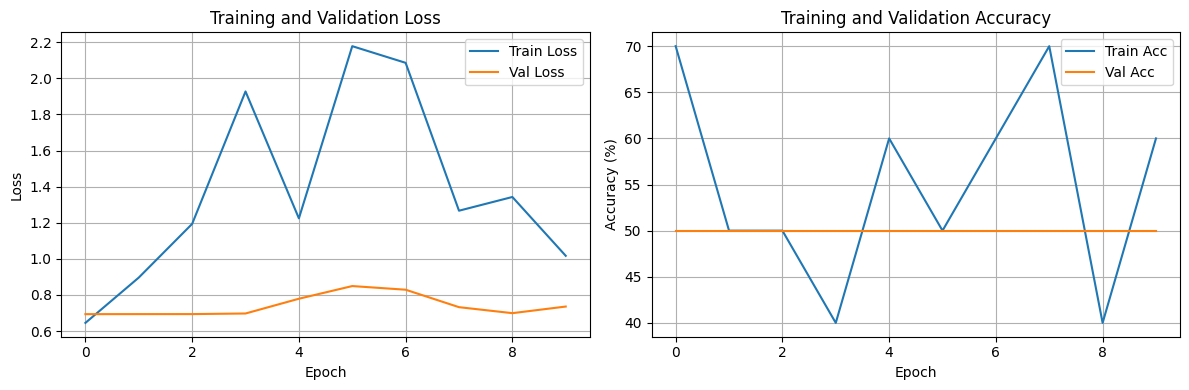

CNN Image Classification System Ready!

To use this system:
1. Organize your data: data/train/class1/, data/train/class2/, etc.
2. Uncomment the example usage code above
3. Run the script to train your model
4. Check 'best_model.pth' for the trained weights


In [16]:
if __name__ == '__main__':

    # Define transforms
    train_transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    val_transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    # Create dummy directories and files for demonstration
    data_dir = Path('data')
    train_dir = data_dir / 'train'
    val_dir = data_dir / 'val'

    for class_name in ['class_a', 'class_b']:
        (train_dir / class_name).mkdir(parents=True, exist_ok=True)
        (val_dir / class_name).mkdir(parents=True, exist_ok=True)
        # Create dummy image files
        for i in range(5):  # 5 dummy images per class
            dummy_image_path = train_dir / class_name / f'image_{i}.jpg'
            Image.new('RGB', (128, 128), color = (i*50, i*100, i*150)).save(dummy_image_path)
            dummy_image_path = val_dir / class_name / f'image_{i}.jpg'
            Image.new('RGB', (128, 128), color = (i*50, i*100, i*150)).save(dummy_image_path)

    # Create datasets (replace with your data paths)
    train_dataset = ImageDataset(Path('data/train'), transform=train_transform)
    val_dataset = ImageDataset(Path('data/val'), transform=val_transform)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

    # Initialize model
    num_classes = len(train_dataset.classes)
    model = CNN_Classifier(num_classes=num_classes)

    # Train the model
    model, history = train_model(model, train_loader, val_loader, num_epochs=10, lr=0.001)

    # Plot results
    plot_training_history(history)

    print("CNN Image Classification System Ready!")
    print("\nTo use this system:")
    print("1. Organize your data: data/train/class1/, data/train/class2/, etc.")
    print("2. Uncomment the example usage code above")
    print("3. Run the script to train your model")
    print("4. Check 'best_model.pth' for the trained weights")